In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statistics import linear_regression
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

### Load in the tidy numbers file from summary_data

In [12]:
all_runs = pd.read_csv("summary_data/tidy_numbers.csv")
# Jump through some hopes to reomve suspect data...
numerical=all_runs.iloc[:,2:]
numerical.mask(abs(numerical) > 1e6, np.nan,inplace=True)
#numerical.mask(abs(numerical) < 1e-6, np.nan,inplace=True)
all_runs.iloc[:,2:]=numerical
all_runs[10:20]

,model,experiment,years,GMTemp,ATL3 mean,ATL3 stddev,Nino34 stddev,AtlNino mean,AtlNino stddev,AMM AnnCycAmp,...,NEB rain djf stddev,r(atl3.nino34),ATL3 Period,ENSO Period,AMM Period,ATL3-sst-interann-stdev,ATL3-pr-interann-stdev,ATL3-sst-interjja-stdev,ATL3-pr-interjja-stdev,r(atl3.amo)
10,AWI-ESM-old,midHolocene-cal-adj,100,12.63620,26.2015,0.435787,0.615068,26.2015,0.436503,6.05362,...,0.501391,0.195511,1.88679,4.54545,7.69231,0.244898,0.745724,0.293235,2.092610,NaN
11,BCC-CSM1-1,abrupt4xCO2,150,18.60270,29.8108,0.286992,0.628354,30.3287,0.286992,7.77558,...,0.474613,0.129655,7.75000,2.81818,7.75000,0.163328,0.670436,0.349624,0.698110,-0.202870
12,BCC-CSM1-1,midHolocene-cal-adj,100,13.62840,26.3226,0.371127,0.663096,26.3226,0.371131,7.66684,...,0.477150,-0.026969,5.55556,1.72414,5.55556,0.239241,0.830011,0.457699,1.250820,-0.139508
13,BCC-CSM1-1,piControl,500,13.71050,26.6758,0.389414,0.695788,26.6758,0.389472,7.45230,...,0.518141,0.041572,7.93651,2.11864,6.17284,0.254960,0.909718,0.518995,1.530020,-0.084680
14,C20-Reanalysis,C20-Reanalysis,180,14.45790,26.3367,0.580604,0.779520,26.3367,0.581269,7.12309,...,0.572958,0.033434,5.00000,3.67347,4.86486,0.358177,0.441260,0.537118,0.328739,0.106572
15,CCSM4,abrupt4xCO2,151,18.19950,29.9846,0.347385,0.946268,30.3334,0.347386,6.52903,...,0.275253,0.315150,4.42857,3.87500,7.75000,0.243269,0.565057,0.367645,0.850487,0.148349
16,CCSM4,lgm-cal-adj,101,8.41792,25.1894,0.458758,0.873097,25.1894,0.458870,6.56372,...,0.436616,-0.353691,4.80952,4.04000,4.20833,0.302976,0.670583,0.573242,2.085670,0.002149
17,CCSM4,midHolocene-cal-adj,301,13.13100,27.0804,0.394765,1.007980,27.0804,0.394849,6.61945,...,0.368030,0.104000,5.10170,5.10170,5.10170,0.268934,0.588071,0.414772,1.482730,0.027327
18,CCSM4,piControl,1051,13.33400,27.3350,0.406756,1.050230,27.3350,0.407018,6.47268,...,0.403366,-0.096317,4.23790,3.92164,5.50262,0.279612,0.607492,0.471919,1.735530,-0.043492
19,CESM2,abrupt4xCO2,150,21.27240,33.2194,0.248443,0.669883,34.8523,0.248446,6.35432,...,0.472235,0.135777,5.16667,2.06667,7.75000,0.194442,0.626153,0.255452,1.472760,-0.240593


Select the lgm runs (we'll take the calednar adjusted ones).

Then duplicate this and populate with the piControl equivalent numbers

In [13]:
lgm=all_runs.loc[all_runs['experiment'] == 'lgm-cal-adj']
lgm.set_index('model', inplace = True)
all_pis=all_runs.loc[all_runs['experiment'] == 'piControl']
all_pis.set_index('model', inplace = True)
lgm_pis=all_pis[all_pis.index.isin(lgm.index)]
# drop the experiment and years columns
lgm_pis.drop(['experiment','years'],axis=1, inplace=True)
lgm.drop(['experiment','years'],axis=1, inplace=True)
# Create a difference grid
lgm_diff=lgm-lgm_pis
lgm_diff['experiment']='lgm'
lgm_diff['run']=list(range(0,np.size(lgm.index)))
lgm_diff.reset_index(inplace=True)
lgm_diff.set_index('run',inplace=True)
lgm_diff

,model,GMTemp,ATL3 mean,ATL3 stddev,Nino34 stddev,AtlNino mean,AtlNino stddev,AMM AnnCycAmp,AMM mean,AMM stddev,...,r(atl3.nino34),ATL3 Period,ENSO Period,AMM Period,ATL3-sst-interann-stdev,ATL3-pr-interann-stdev,ATL3-sst-interjja-stdev,ATL3-pr-interjja-stdev,r(atl3.amo),experiment
run,,,,,,,,,,,,,,,,,,,,,
0,AWI-CM-1-1-LR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,lgm
1,AWI-ESM-1-1-LR,-3.71394,-1.5402,0.045615,0.146279,-1.5402,0.045074,0.79117,-0.229227,0.049754,...,0.025701,0.20270,-1.31362,0.23810,0.023975,0.005319,0.097718,0.268470,-0.113669,lgm
2,AWI-ESM-old,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,lgm
3,CCSM4,-4.91608,-2.1456,0.052002,-0.177133,-2.1456,0.051852,0.09104,-0.118035,0.020961,...,-0.257374,0.57162,0.11836,-1.29429,0.023364,0.063091,0.101323,0.350140,0.045641,lgm
4,CNRM-CM5,-2.63480,-1.4687,-0.003960,0.020978,-1.4687,-0.004890,0.31244,0.050328,-0.013339,...,-0.024439,-2.41297,0.12661,-1.29928,-0.013341,-0.049764,-0.008784,-0.157190,-0.004531,lgm
5,COSMOS-ASO,-5.47037,-3.9999,0.209955,0.003940,-3.9999,0.201856,0.74187,0.260643,-0.036029,...,0.021294,0.90768,1.35508,-0.76754,0.172391,-0.262666,0.025248,0.037660,0.114773,lgm
6,FGOALS-g2,-4.58484,-2.8489,0.043447,-0.348958,-2.8489,0.042782,0.08047,-0.128027,0.078076,...,-0.277769,1.42045,-0.34078,-1.76086,0.043412,0.034186,0.081789,0.195030,0.042913,lgm
7,GISS-E2-R,-4.80725,-1.8912,0.027831,-0.162594,-1.8912,0.027849,-0.42659,-0.626854,0.074722,...,-0.169000,3.93291,-1.63174,-1.93015,0.019337,0.098620,0.051354,0.353490,0.102716,lgm
8,INM-CM4-8,-3.72303,-1.2889,0.145785,0.076214,-1.2889,0.140282,0.30745,-3.210517,0.317259,...,0.137345,-4.59478,0.52968,1.98263,0.084050,0.577534,0.175200,1.975299,0.253801,lgm


In [14]:
lig127k=all_runs.loc[all_runs['experiment'] == 'lig127k-cal-adj']
lig127k.set_index('model', inplace = True)
lig127k_pis=all_pis[all_pis.index.isin(lig127k.index)]
# drop the experiment and years columns
lig127k_pis.drop(columns=['experiment','years'],inplace=True)
lig127k.drop(columns=['experiment','years'],inplace=True)
# Create a difference grid
lig127k_diff=lig127k-lig127k_pis
lig127k_diff['experiment']='lig127k'
lig127k_diff['run']=list(range(50,50+np.size(lig127k.index)))
lig127k_diff.reset_index(inplace=True)
lig127k_diff.set_index('run',inplace=True)
lig127k_pcts=100*(lig127k-lig127k_pis)/lig127k_pis
lig127k_diff

,model,GMTemp,ATL3 mean,ATL3 stddev,Nino34 stddev,AtlNino mean,AtlNino stddev,AMM AnnCycAmp,AMM mean,AMM stddev,...,r(atl3.nino34),ATL3 Period,ENSO Period,AMM Period,ATL3-sst-interann-stdev,ATL3-pr-interann-stdev,ATL3-sst-interjja-stdev,ATL3-pr-interjja-stdev,r(atl3.amo),experiment
run,,,,,,,,,,,,,,,,,,,,,
50,ACCESS-ESM1-5,0.4740,NaN,-0.115760,-0.114513,NaN,-0.114982,0.98156,0.917830,-0.011128,...,0.026598,-5.14286,0.89184,0.63492,-0.088097,-0.442552,-0.216145,-1.282359,NaN,lig127k
51,AWI-CM-1-1-LR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,lig127k
52,AWI-ESM-1-1-LR,-0.0981,-0.7774,-0.025851,-0.147396,-0.7774,-0.026393,-0.67446,0.452882,-0.041555,...,-0.190570,0.27778,1.48810,3.80953,-0.007716,-0.044848,-0.038624,-0.348710,0.089122,lig127k
53,AWI-ESM-old,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,lig127k
54,CESM2,0.0534,-0.3136,-0.026407,-0.227121,-0.3136,-0.026035,0.35612,0.048310,-0.018903,...,0.164806,1.66299,1.95972,1.97681,0.000167,-0.178651,-0.061881,-0.611060,0.046349,lig127k
55,CNRM-CM6-1,0.4924,0.0366,-0.024749,-0.195641,0.0366,-0.024334,-0.58235,0.156544,-0.024103,...,-0.088535,3.05644,-0.58279,-0.66082,-0.015631,-0.130875,-0.066429,-0.771550,-0.046924,lig127k
56,FGOALS-f3-L,-0.2616,-0.7187,-0.060795,-0.270160,-0.7187,-0.061246,0.38478,0.302060,-0.082742,...,0.075057,0.54773,0.72384,0.89555,-0.023382,-0.267709,-0.075353,-0.950410,-0.095079,lig127k
57,FGOALS-g3,0.4364,-0.5635,0.013314,-0.275393,-0.5562,0.012970,0.35722,0.297784,-0.047087,...,0.285461,-0.56427,-0.56427,-4.33136,-0.021603,-0.570731,-0.159806,-1.543930,-0.021427,lig127k
58,GISS-E2-1-G,0.0188,-0.3218,-0.001263,0.003790,-0.3218,-0.001311,-0.23442,0.273985,-0.017904,...,0.073712,-0.61610,-0.61610,-0.31980,0.000755,-0.276773,0.008799,-0.954670,-0.011157,lig127k


In [15]:
midHolocene=all_runs.loc[all_runs['experiment'] == 'midHolocene-cal-adj']
midHolocene.set_index('model', inplace = True)
midHolocene_pis=all_pis[all_pis.index.isin(midHolocene.index)]
# drop the experiment and years columns
midHolocene_pis.drop(['experiment','years'],axis=1, inplace=True)
midHolocene.drop(['experiment','years'],axis=1, inplace=True)
# Create a difference grid
midHolocene_diff=midHolocene-midHolocene_pis
midHolocene_diff['experiment']='midHolocene'
midHolocene_diff['run']=list(range(100,100+np.size(midHolocene.index)))
midHolocene_diff.reset_index(inplace=True)
midHolocene_diff.set_index('run',inplace=True)
midHolocene_pcts=100*(midHolocene-midHolocene_pis)/midHolocene_pis
midHolocene_diff

,model,GMTemp,ATL3 mean,ATL3 stddev,Nino34 stddev,AtlNino mean,AtlNino stddev,AMM AnnCycAmp,AMM mean,AMM stddev,...,r(atl3.nino34),ATL3 Period,ENSO Period,AMM Period,ATL3-sst-interann-stdev,ATL3-pr-interann-stdev,ATL3-sst-interjja-stdev,ATL3-pr-interjja-stdev,r(atl3.amo),experiment
run,,,,,,,,,,,,,,,,,,,,,
100,AWI-ESM-1-1-LR,-0.3768,-0.7342,-0.008865,-0.038755,-0.7342,-0.009293,-0.63564,0.442932,-0.010027,...,-0.273570,0.27778,-0.59523,0.11495,-0.001278,0.021314,0.037978,0.054110,-0.022036,midHolocene
101,AWI-ESM-old,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,midHolocene
102,BCC-CSM1-1,-0.0821,-0.3532,-0.018287,-0.032692,-0.3532,-0.018341,0.21454,0.171293,-0.019910,...,-0.068541,-2.38095,-0.39450,-0.61728,-0.015719,-0.079707,-0.061296,-0.279200,-0.054828,midHolocene
103,CCSM4,-0.2030,-0.2546,-0.011991,-0.042250,-0.2546,-0.012169,0.14677,0.049437,-0.020296,...,0.200317,0.86380,1.18006,-0.40092,-0.010678,-0.019421,-0.057147,-0.252800,0.070819,midHolocene
104,CESM2,-0.1485,-0.4185,0.011939,-0.099880,-0.4185,0.011845,0.02584,0.266240,-0.012808,...,0.121508,1.75405,0.69904,4.15459,0.019377,-0.079085,-0.005994,-0.233825,0.026436,midHolocene
105,CNRM-CM5,0.2430,-0.1222,0.034965,-0.071819,-0.1222,0.035272,-0.34682,0.178578,-0.026529,...,0.061087,-0.69130,1.10700,-2.09294,0.003892,0.000656,0.044133,-0.114550,0.017548,midHolocene
106,CSIRO-Mk3-6-0,0.0780,-0.2571,0.031530,0.125861,-0.2571,0.031389,0.17629,0.112000,-0.002009,...,-0.136155,-0.69659,-3.96635,2.48398,-0.004100,0.003941,-0.026898,-0.026354,-0.075395,midHolocene
107,CSIRO-Mk3L-1-2,0.0517,-0.1666,-0.019276,-0.093669,-0.1666,-0.019375,0.43355,0.205760,-0.043335,...,-0.080421,-0.12401,0.29370,-0.16801,-0.014872,0.014203,-0.014166,0.043883,0.093196,midHolocene
108,EC-Earth3-LR,0.0172,-0.5168,0.018200,-0.088837,-0.5168,0.021764,-0.01874,0.438704,0.002904,...,0.063296,2.03236,0.96142,3.62873,0.044216,-0.077631,0.042618,-0.309960,0.157014,midHolocene


In [16]:
abrupt4xCO2=all_runs.loc[all_runs['experiment'] == 'abrupt4xCO2']
abrupt4xCO2.set_index('model', inplace = True)
abrupt4xCO2_pis=all_pis[all_pis.index.isin(abrupt4xCO2.index)]
# drop the experiment and years columns
abrupt4xCO2_pis.drop(['experiment','years'],axis=1, inplace=True)
abrupt4xCO2.drop(['experiment','years'],axis=1, inplace=True)
# Create a difference grid
abrupt4xCO2_diff=abrupt4xCO2-abrupt4xCO2_pis
# add back in the experiment name
abrupt4xCO2_diff['experiment']='abrupt4xCO2'
abrupt4xCO2_diff['run']=list(range(150,150+np.size(abrupt4xCO2.index)))
abrupt4xCO2_diff.reset_index(inplace=True)
abrupt4xCO2_diff.set_index('run',inplace=True)

In [17]:
abrupt4xCO2_diff

,model,GMTemp,ATL3 mean,ATL3 stddev,Nino34 stddev,AtlNino mean,AtlNino stddev,AMM AnnCycAmp,AMM mean,AMM stddev,...,r(atl3.nino34),ATL3 Period,ENSO Period,AMM Period,ATL3-sst-interann-stdev,ATL3-pr-interann-stdev,ATL3-sst-interjja-stdev,ATL3-pr-interjja-stdev,r(atl3.amo),experiment
run,,,,,,,,,,,,,,,,,,,,,
150,BCC-CSM1-1,4.8922,3.1350,-0.102422,-0.067434,3.6529,-0.102480,0.32328,0.394271,-0.080473,...,0.088083,-0.18651,0.69954,1.57716,-0.091632,-0.239282,-0.169371,-0.831910,-0.118190,abrupt4xCO2
151,CCSM4,4.8655,2.6496,-0.059371,-0.103962,2.9984,-0.059632,0.05635,0.368372,-0.009384,...,0.411467,0.19067,-0.04664,2.24738,-0.036343,-0.042435,-0.104274,-0.885043,0.191841,abrupt4xCO2
152,CESM2,7.2204,5.4800,-0.146891,-0.470807,7.1129,-0.147027,-0.61412,-1.735061,-0.113649,...,0.069118,1.22966,-1.66467,4.12681,-0.097293,0.011236,-0.159906,0.516168,-0.170463,abrupt4xCO2
153,CNRM-CM5,5.1965,3.3075,-0.049864,0.097066,3.8876,-0.051117,-0.30546,-0.093340,-0.016844,...,0.243996,-1.24786,-0.42995,0.89516,-0.068391,0.033643,-0.085640,0.053450,-0.154709,abrupt4xCO2
154,CNRM-CM6-1,6.7382,4.6413,-0.058559,0.135754,5.6171,-0.059539,1.53965,-0.444566,-0.045255,...,0.100920,1.34215,-0.52319,-1.63231,-0.043279,0.017855,-0.069024,-0.236190,0.231581,abrupt4xCO2
155,CSIRO-Mk3-6-0,5.7115,4.1039,-0.066835,0.278314,5.2737,-0.071529,0.53949,0.071410,-0.115100,...,0.104516,0.64902,-1.61250,-3.57675,-0.051916,0.011970,-0.102730,-0.070728,-0.000243,abrupt4xCO2
156,FGOALS-f3-L,5.1749,2.7498,-0.056768,-0.038630,3.0610,-0.057618,0.18965,1.000920,0.028814,...,0.068959,4.19937,0.14737,-0.06949,-0.030089,0.149614,-0.073418,-0.557530,-0.197736,abrupt4xCO2
157,FGOALS-g2,5.6582,3.6504,-0.055059,-0.203131,4.3426,-0.055871,0.35307,0.195049,-0.041666,...,0.159783,1.30357,0.40096,-1.13964,-0.024936,-0.141941,-0.066814,-0.619000,0.167188,abrupt4xCO2
158,FGOALS-s2,5.9333,4.7480,-0.080821,0.280830,5.7642,-0.083607,0.57775,-1.282015,-0.034614,...,0.117244,-2.11875,-4.26325,-4.44269,-0.064139,-0.016922,-0.223141,0.564200,0.228289,abrupt4xCO2


In [18]:
all_diffs=pd.concat([lgm_diff,midHolocene_diff,lig127k_diff,abrupt4xCO2_diff])
not_abrup4xCO2_diffs=pd.concat([lgm_diff,midHolocene_diff,lig127k_diff])
orb_diffs=pd.concat([midHolocene_diff,lig127k_diff])

In [19]:
# Add some colors to allow for convenient plotting...
all_diffs['color'] = all_diffs['experiment']
all_diffs['color'] = all_diffs['color'].map({'lgm':'tab:blue',
                             'midHolocene':'tab:olive',
                             'lig127k':'tab:green',
                             'abrupt4xCO2':'tab:red'},
                             na_action=None)

<Figure size 640x480 with 0 Axes>

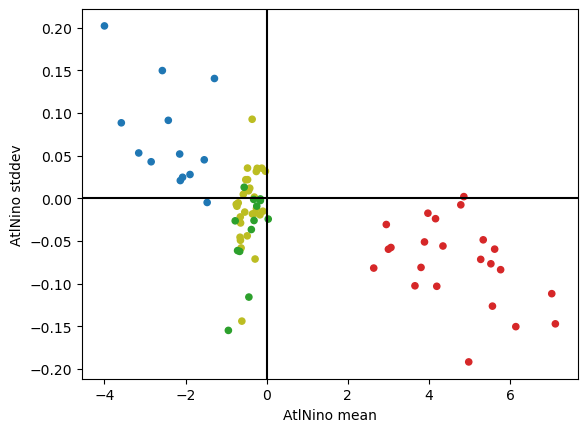

In [20]:
fig = plt.figure()
fig=all_diffs.plot.scatter(x='AtlNino mean',y='AtlNino stddev',c='color').get_figure()
plt.axhline(0,color='black')
plt.axvline(0,color='black')
#res = linear_regression(all_diffs['AtlNino mean'],all_diffs['AtlNino stddev'],proportional=True)
#est_y=res.slope*all_diffs['AtlNino mean']
#resid=est_y-all_diffs['AtlNino stddev']
#stderr=np.sqrt(np.sum(resid)/(len(all_diffs['AtlNino mean'])-2))
#tinv = lambda p, df: abs(stats.t.ppf(p/2, df))
#ts = tinv(0.05, len(all_diffs['AtlNino mean'])-2)
#print(f"slope: {res.slope:.6f}")
#print(f"slope (95%): {res.slope:.6f} ({res.slope-ts*stderr:.6f} to {res.slope+ts*stderr:.6f})")
fig.savefig('plots/AtlNino_w_mean.png')

<Figure size 640x480 with 0 Axes>

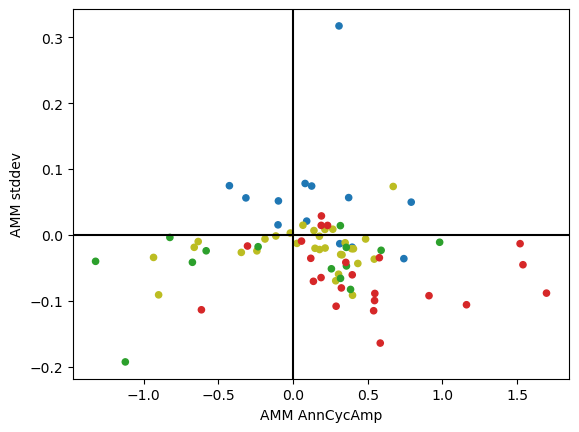

In [21]:
fig = plt.figure()
fig=all_diffs.plot.scatter(x='AMM AnnCycAmp',y='AMM stddev',c='color').get_figure()
plt.axhline(0,color='black')
plt.axvline(0,color='black')
fig.savefig('plots/AMM_w_AnnCycAmp.png')

<Figure size 640x480 with 0 Axes>

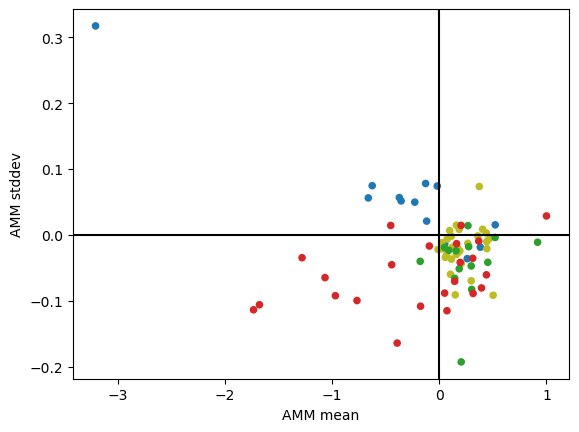

In [22]:
fig = plt.figure()
fig=all_diffs.plot.scatter(x='AMM mean',y='AMM stddev',c='color').get_figure()
plt.axhline(0,color='black')
plt.axvline(0,color='black')
fig.savefig('plots/AMM_w_mean.png')

<Figure size 640x480 with 0 Axes>

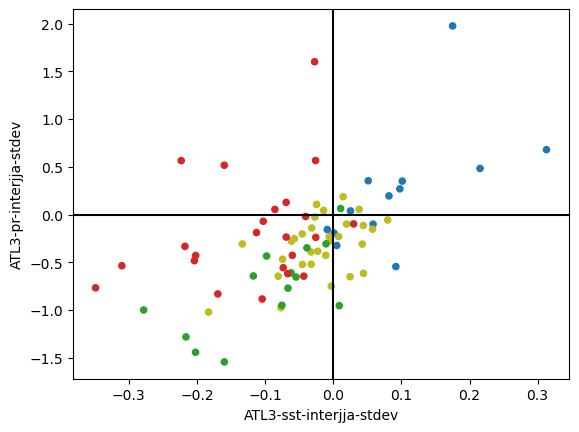

In [23]:
fig = plt.figure()
fig=all_diffs.plot.scatter(x='ATL3-sst-interjja-stdev',y='ATL3-pr-interjja-stdev',c='color').get_figure()
plt.axhline(0,color='black')
plt.axvline(0,color='black')
fig.savefig('plots/Rainfall_vs_SST_variability_changes.png')

<Figure size 640x480 with 0 Axes>

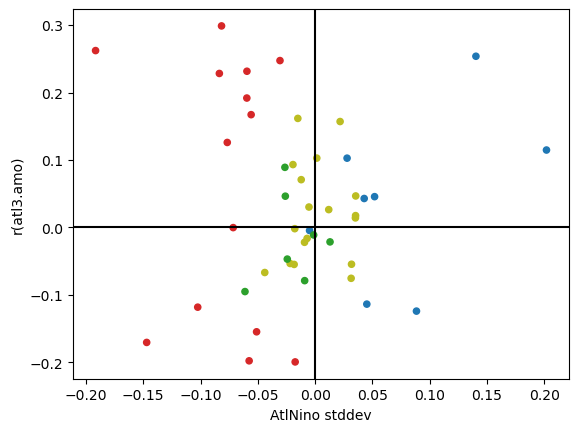

In [24]:
fig = plt.figure()
fig=all_diffs.plot.scatter(x='AtlNino stddev',y='r(atl3.amo)',c='color').get_figure()
plt.axhline(0,color='black')
plt.axvline(0,color='black')
fig.savefig('plots/amo_corr_w_AtlNino_stddev.png')